# HW08 Dynamics

In [1]:
import transforms as tr
import transforms_symbolic as st
import kinematics as kin
from dynamics import SerialArmDyn
import kinematics_symbolic as kins
import time

import numpy as np
import sympy as sm
from sympy import UnevaluatedExpr as uneval
from IPython.display import display, Math
from sympy.physics.vector.printing import vlatex

from visualization import VizScene 
from visualization import ArmPlayer

np.set_printoptions(precision=4, suppress=True)

## Question 1: Find the moments of inertia and cross products of inertia of a uniform rectangular solid 

With sides of length a, b, and c with respect to a coordinate frame with the origin at the center of
mass. For this coordinate frame, a is in the x-direction, b in the y-direction, and c in the z-direction. See associated figure below. You can calculate this using a table, or the definition
of the inertia tensor.

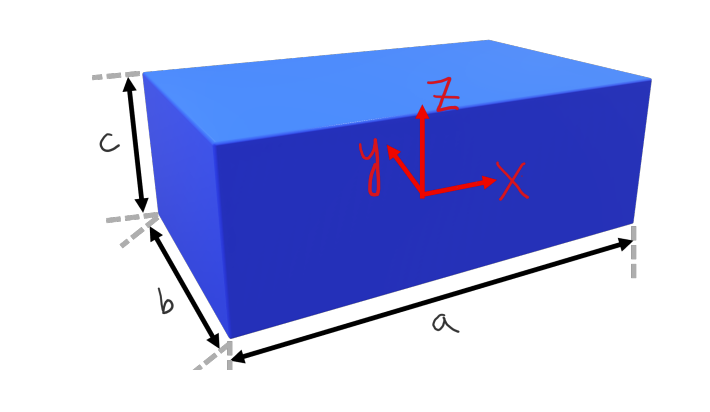

$$
I = \begin{bmatrix}
    I_{xx} & I_{xy} & I_{xz} \\
    I_{yx} & I_{yy} & I_{yz} \\
    I_{zx} & I_{zy} & I_{zz} \\
\end{bmatrix}
$$

$$
I_{xx} = \iiint (y^2 + z^2) \, \rho(x, y, z) \, dx \, dy \, dz
\qquad I_{xy} = I_{yx} = - \iiint x y \, \rho(x, y, z) \, dx \, dy \, dz
$$

$$
I_{yy} = \iiint (x^2 + z^2) \, \rho(x, y, z) \, dx \, dy \, dz
\qquad I_{xz} = I_{zx} = - \iiint x z \, \rho(x, y, z) \, dx \, dy \, dz
$$

$$
I_{zz} = \iiint (x^2 + y^2) \, \rho(x, y, z) \, dx \, dy \, dz
\qquad I_{yz} = I_{zy} = - \iiint y z \, \rho(x, y, z) \, dx \, dy \, dz
$$


### Part 1: Moment of inertia at center of mass

In [2]:
a, b, c, x, y, z, rho = sm.symbols(r'a b c x y z \rho', real=True)
Ixx, Iyy, Izz, Ixy, Ixz, Iyz = sm.symbols(r'I_{xx} I_{yy} I_{zz} I_{xy} I_{xz} I_{yz}')
J = sm.MatrixSymbol(r'J', 3, 3)
# define variable dictionary
vd = {}

vd[J] = sm.Matrix([[Ixx, Ixy, Ixz],
                   [Ixy, Iyy, Iyz],
                   [Ixz, Ixy, Izz]])

display(Math(fr'{J}=' + vlatex(vd[J])))

<IPython.core.display.Math object>

In [3]:
bounds = (x,-a/2,a/2), (y,-b/2,b/2), (z,-c/2,c/2) # x, y, z bounds

# define integrals
vd[Ixx] = sm.Integral(rho*(y**2 + z**2), *bounds)
vd[Iyy] = sm.Integral(rho*(x**2 + z**2), *bounds)
vd[Izz] = sm.Integral(rho*(x**2 + y**2), *bounds)

vd[Ixy] = -sm.Integral(x*y*rho, *bounds)
vd[Ixz] = -sm.Integral(x*z*rho, *bounds)
vd[Iyz] = -sm.Integral(y*z*rho, *bounds)

display(Math(fr'{J}=' + vlatex( vd[J].subs(vd) )))

<IPython.core.display.Math object>

In [4]:
vd[J] = vd[J].subs(vd).doit()
display(Math(fr'\Large {J}=' + vlatex( vd[J] )))

<IPython.core.display.Math object>

In [5]:
m = sm.symbols(r'm')

vd[J] = sm.expand(vd[J]).applyfunc(lambda expr: sm.collect(expr, rho*a*b*c)) # collect rho*a*b*c
vd[J] = vd[J].subs({rho*a*b*c: m}) # sub in values
vd[J] = sm.expand(vd[J]).applyfunc(lambda expr: sm.collect(expr, m)) # collect m values
print('sub in m = rho*volume = rho*a*b*c')
display(Math(fr'\Large {J}=' + vlatex( vd[J] )))

sub in m = rho*volume = rho*a*b*c


<IPython.core.display.Math object>

### Part 2: $J$ at corner

In [6]:
r = sm.symbols(r'r')
r_ix = sm.MatrixSymbol(r'{[r_i]}_\times', 3, 3)
J_corner = sm.MatrixSymbol(r'J_{corner}', 3, 3)

skew = lambda v: sm.Matrix([[0, -v[2], v[1]],
                            [v[2], 0, -v[0]],
                            [-v[1], v[0], 0]])

print('vector from new point to COM')
vd[r] = sm.Matrix([a/2, b/2, c/2])
vd[r_ix] = skew(vd[r])

display(Math(fr'{r}=' + vlatex(vd[r]) +\
             fr', \quad {r_ix}=' + vlatex(vd[r_ix])))

vector from new point to COM


<IPython.core.display.Math object>

In [7]:
# * does matrix multiplication in sympy
vd[J_corner] = J - m * r_ix @ r_ix
display(Math(fr'{J_corner}=' + vlatex(vd[J_corner])))

vd[J_corner] = vd[J_corner].subs(vd).doit()
vd[J_corner] = sm.simplify(vd[J_corner])
display(Math(fr'\Large {J_corner}=' + vlatex(vd[J_corner])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Part 2 Test Cases

### Part a

These are the intermediate values for HW 08, Problem 2, part a), where link lengths are [0.4, 0.4, 0.4] and distance to center of mass for each link is [0.2, 0.2, 0.2] as described in the homework: 

```
ac =

   -0.0548   -0.2393   -0.2041
   -0.1047    0.0342    0.4866
         0         0         0
```
         
here are the forces at the joints too:

```
f =

   20.0753   18.8923    6.7326
   20.3562    0.2339   -6.4501
         0         0         0
```
where both of these are expressed in the frames where they are calculated in the algorithm (or in other words, frame $i$). So for the first column, that would be in frame 1, the 2nd column in frame 2, and the third column in frame 3.

In [8]:
dh = [[0, 0, 0.4, 0],
      [0, 0, 0.4, 0],
      [0, 0, 0.4, 0]]

joint_type = ['r', 'r', 'r']

link_masses = [1, 1, 1]

# defining three different centers of mass, one for each link
r_coms = [np.array([-0.2, 0, 0]), 
          np.array([-0.2, 0, 0]), 
          np.array([-0.2, 0, 0])]

link_inertias = []
for i in range(len(joint_type)):
    iner = 0.01 # link_masses[i] / 12 * dh[i][2]**2
    
    # this inertia tensor is only defined as having Iyy, and Izz non-zero
    link_inertias.append(np.array([[0, 0, 0], [0, iner, 0], [0, 0, iner]]))


arm = SerialArmDyn(dh,
                   jt=joint_type,
                   mass=link_masses,
                   r_com=r_coms,
                   link_inertia=link_inertias)

link_inertias

[array([[0.  , 0.  , 0.  ],
        [0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.01]]),
 array([[0.  , 0.  , 0.  ],
        [0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.01]]),
 array([[0.  , 0.  , 0.  ],
        [0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.01]])]

In [9]:
g=np.array([0, -9.81, 0])

q = [np.pi/4.0] * 3
qd = [np.pi/6, -np.pi/4, np.pi/3]
qdd = [-np.pi/6, np.pi/3, np.pi/6]
tau, wrenches = arm.rne(q, qd, qdd, g=g)
print('tau      = ', tau)
print('wrenches = \n', wrenches)

tau      =  [ 5.5833 -1.1876 -1.2796]
wrenches = 
 [[20.0753 18.8923  6.7326]
 [20.3562  0.2339 -6.4501]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 5.5833 -1.1876 -1.2796]]


### Part b and c, find mass matrix and Coriolis vector:

In [10]:
# find mass matrices
arm.get_M(q)

array([[1.0825, 0.5428, 0.1066],
       [0.5428, 0.3731, 0.1066],
       [0.1066, 0.1066, 0.05  ]])

In [12]:
arm.get_C(q, qd)

array([-0.0235,  0.0374,  0.0258])